In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm

import numpy as np
import qutip as qt

In [2]:
omeg1 = 0.25
omeg2 = 0.5

gam1 = 1
gam2 = 4
alpha = 3
kappa = 1

lamb1 = (gam1 + gam2) / 4 - np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)
lamb2 = (gam1 + gam2) / 4 + np.sqrt((gam1**2 + gam2**2 + 8 * kappa**2) / 8)

In [3]:
times_qmc = np.linspace(0, 2.5, 51)
times_me = np.linspace(0, 2.5, 201)
nmmc_options = {"map": "parallel",
                "keep_runs_results": True,
                "norm_steps": 10}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced"}  # options shared by all solvers
ntraj = 10000

In [4]:
# Initial state of the system
psi0 = (
    np.sqrt(1/3) * qt.basis(4, 0)
    + np.sqrt(1/3) * qt.basis(4, 1)
    + np.sqrt(1/3) * qt.basis(4, 2)
)

L1 = qt.Qobj(np.array([[0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 0, 0, 0],
                       [0, 0, 1, 0]])).dag()
L2 = qt.Qobj(np.array([[0, 0, 0, 0],
                       [0, 0, 0, 0],
                       [1, 0, 0, 0],
                       [0, 1, 0, 0]])).dag()

norm1 = np.sqrt(
    1 + (gam2 - gam1 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2
    / ((gam1 + gam2) ** 2 + 16 * kappa**2))
norm2 = np.sqrt(
    1 + (gam2 - gam1 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))**2
    / ((gam1 + gam2) ** 2 + 16 * kappa**2))
U = qt.Qobj(np.array([
    [(gam1 - gam2 - np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))
     / (gam1 + gam2 + 4j*kappa) / norm1,
     (gam1 - gam2 + np.sqrt(2) * np.sqrt(gam1**2 + gam2**2 + 8*kappa**2))
     / (gam1 + gam2 + 4j*kappa) / norm2],
    [1 / norm1, 1 / norm2]]))

# Write \sigma_\pm^{1,2} in terms of L_{1,2} using the explicit definition of U
Udag = U.dag()
sigmam1 = Udag[0, 0] * L1 + Udag[1, 0] * L2
sigmam2 = Udag[0, 1] * L1 + Udag[1, 1] * L2
sigmap1 = sigmam1.dag()
sigmap2 = sigmam2.dag()

H = ((omeg1 + alpha) * sigmap1 * sigmam1
     + (omeg2 + alpha + kappa) * sigmap2 * sigmam2
     + (alpha + kappa / 2 - 1j * (gam1 - gam2) / 8) * sigmap2 * sigmam1
     + (alpha + kappa / 2 - 1j * (gam2 - gam1) / 8) * sigmap1 * sigmam2)

In [5]:
eops = [qt.basis(4, 0) * qt.basis(4, 1).dag(),
        qt.basis(4, 0) * qt.basis(4, 2).dag(),
        qt.basis(4, 1) * qt.basis(4, 2).dag()]

MCSol = qt.nm_mcsolve(H, psi0, times_qmc, ntraj=ntraj,
                       options=(options | nmmc_options),
                       ops_and_rates=[[L1, lamb1], [L2, lamb2]],
                       e_ops=eops)

 Total run time:  20.35s*] Elapsed 20.34s / Remaining 00:00:00:00*         4%           ] Elapsed 0.77s / Remaining 00:00:00:18[*         6%           ] Elapsed 1.21s / Remaining 00:00:00:18[**        9%           ] Elapsed 1.85s / Remaining 00:00:00:18[***      13%           ] Elapsed 2.72s / Remaining 00:00:00:18[****     16%           ] Elapsed 3.32s / Remaining 00:00:00:17[****     16%           ] Elapsed 3.34s / Remaining 00:00:00:17[*****    22%           ] Elapsed 4.42s / Remaining 00:00:00:15[*******  29%           ] Elapsed 5.99s / Remaining 00:00:00:14[******** 34%           ] Elapsed 7.01s / Remaining 00:00:00:13[*********70%****       ] Elapsed 14.43s / Remaining 00:00:00:06[*********86%********   ] Elapsed 17.65s / Remaining 00:00:00:02[*********92%*********  ] Elapsed 18.75s / Remaining 00:00:00:01[*********97%********** ] Elapsed 19.82s / Remaining 00:00:00:00


In [6]:
pop_state_01_mean = np.mean(MCSol.e_data[0], axis=0)
pop_state_01_err_re= np.std(np.real(MCSol.e_data[0]), axis=0) / np.sqrt(ntraj)
pop_state_01_err_im = np.std(np.imag(MCSol.e_data[0]), axis=0) / np.sqrt(ntraj)

pop_state_02_mean = np.mean(MCSol.e_data[1], axis=0)
pop_state_02_err_re= np.std(np.real(MCSol.e_data[1]), axis=0) / np.sqrt(ntraj)
pop_state_02_err_im = np.std(np.imag(MCSol.e_data[1]), axis=0) / np.sqrt(ntraj)

pop_state_12_mean = np.mean(MCSol.e_data[2], axis=0)
pop_state_12_err_re= np.std(np.real(MCSol.e_data[2]), axis=0) / np.sqrt(ntraj)
pop_state_12_err_im = np.std(np.imag(MCSol.e_data[2]), axis=0) / np.sqrt(ntraj)

In [7]:
d_ops = [lamb1 * qt.lindblad_dissipator(L1, L1),
         lamb2 * qt.lindblad_dissipator(L2, L2)]
MESol = qt.mesolve(H, psi0, times_me, d_ops,
                    e_ops=eops,
                    options=options)

 Total run time:   0.04s*] Elapsed 0.04s / Remaining 00:00:00:00


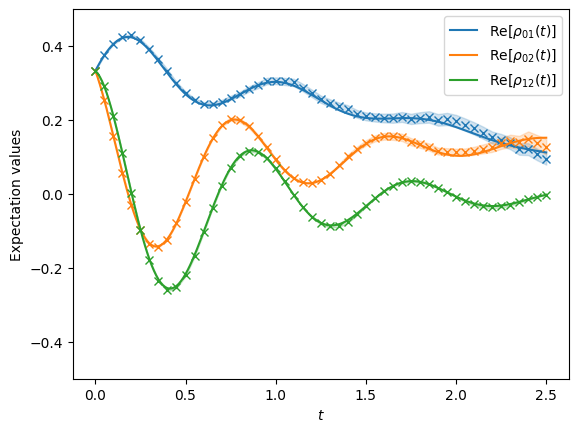

In [8]:
plt.plot(times_me, np.real(MESol.expect[0]), color='C0',
         label=r"$\mathrm{Re}[\rho_{01}(t)]$")
plt.plot(times_qmc, np.real(MCSol.average_expect[0]), 'x', color='C0')
plt.fill_between(
    times_qmc,
    np.real(MCSol.average_expect[0]) - pop_state_01_err_re,
    np.real(MCSol.average_expect[0]) + pop_state_01_err_re,
    alpha=0.2, color='C0'
)

plt.plot(times_me, np.real(MESol.expect[1]), color='C1',
         label=r"$\mathrm{Re}[\rho_{02}(t)]$")
plt.plot(times_qmc, np.real(MCSol.average_expect[1]), 'x', color='C1')
plt.fill_between(
    times_qmc,
    np.real(MCSol.average_expect[1]) - pop_state_02_err_re,
    np.real(MCSol.average_expect[1]) + pop_state_02_err_re,
    alpha=0.2, color='C1'
)


plt.plot(times_me, np.real(MESol.expect[2]), color='C2',
         label=r"$\mathrm{Re}[\rho_{12}(t)]$")
plt.plot(times_qmc, np.real(MCSol.average_expect[2]), 'x', color='C2')
plt.fill_between(
    times_qmc,
    np.real(MCSol.average_expect[2]) - pop_state_12_err_re,
    np.real(MCSol.average_expect[2]) + pop_state_12_err_re,
    alpha=0.2, color='C2'
)

plt.ylim([-0.5, 0.5])

plt.xlabel(r"$t$")
plt.ylabel('Expectation values')
plt.legend()

plt.show()

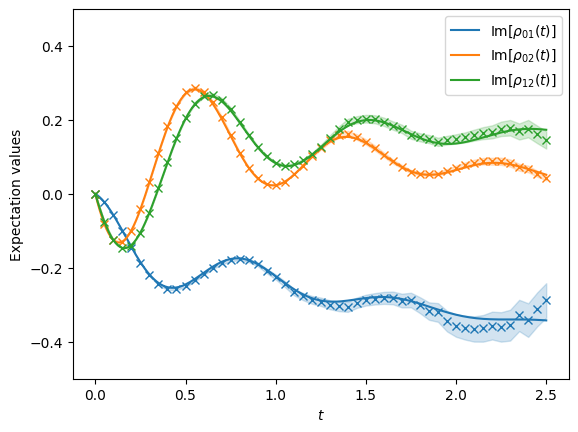

In [9]:
plt.plot(times_me, np.imag(MESol.expect[0]), color='C0',
         label=r"$\mathrm{Im}[\rho_{01}(t)]$")
plt.plot(times_qmc, np.imag(MCSol.average_expect[0]), 'x', color='C0')
plt.fill_between(
    times_qmc,
    np.imag(MCSol.average_expect[0]) - pop_state_01_err_im,
    np.imag(MCSol.average_expect[0]) + pop_state_01_err_im,
    alpha=0.2, color='C0'
)

plt.plot(times_me, np.imag(MESol.expect[1]), color='C1',
         label=r"$\mathrm{Im}[\rho_{02}(t)]$")
plt.plot(times_qmc, np.imag(MCSol.average_expect[1]), 'x', color='C1')
plt.fill_between(
    times_qmc,
    np.imag(MCSol.average_expect[1]) - pop_state_02_err_im,
    np.imag(MCSol.average_expect[1]) + pop_state_02_err_im,
    alpha=0.2, color='C1'
)

plt.plot(times_me, np.imag(MESol.expect[2]), color='C2',
         label=r"$\mathrm{Im}[\rho_{12}(t)]$")
plt.plot(times_qmc, np.imag(MCSol.average_expect[2]), 'x', color='C2')
plt.fill_between(
    times_qmc,
    np.imag(MCSol.average_expect[2]) - pop_state_12_err_im,
    np.imag(MCSol.average_expect[2]) + pop_state_12_err_im,
    alpha=0.2, color='C2'
)

plt.ylim([-0.5, 0.5])

plt.xlabel(r"$t$")
plt.ylabel('Expectation values')
plt.legend()

plt.show()